    Forecast the CocaCola Sales data set. 
    Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. 
    Finally which model you will use for Forecasting.

### Importing the required Libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from pandas import Grouper
from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.formula.api as smf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #SES
from statsmodels.tsa.holtwinters import Holt  # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# importing warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading the dataset

In [2]:
cola = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
cola.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


### Performing EDA on the dataset

In [3]:
# to get the information of the datafile
cola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 804.0+ bytes


In [4]:
# to check the null values of the data
cola.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [5]:
print("Dimensions -",cola.shape)
print("Column names -",cola.columns)

Dimensions - (42, 2)
Column names - Index(['Quarter', 'Sales'], dtype='object')


In [6]:
# Summarizing the dataset
cola.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [7]:
# to check the dimensions of duplicates in the data
print(cola[cola.duplicated()].shape)

# to get the duplicate values from the data
cola[cola.duplicated()]

(0, 2)


,Quarter,Sales


### Feature Engineering

In [8]:
# Converting the Quarters into Years

cola['Quarter_Year'] = cola['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#to convert quarterly periods to datetime in pandas
cola.head()

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987


In [9]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

# converting into datetime formate as the index was not in correct formate.
cola['Date'] = pd.to_datetime(cola['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),
                              dayfirst=True)
cola.head()

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01


In [10]:
# Now, extracting the Quarters and putting them in column
cola['Quarters'] = 0
for i in range(42):
    n = cola['Quarter'][i]
    cola['Quarters'][i] = n[0:2]  
cola.head()

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1


In [11]:
#Creating Dummy Variables for Quarters Variable
dummy = pd.DataFrame(pd.get_dummies(cola['Quarters']))
cola1 = pd.concat((cola, dummy), axis=1)
cola1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [12]:
# Dropping all the unnecessary columns
cola1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
cola1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [13]:
# Making the Date as DateTime index for the Dataframe
cola1.set_index('Date',inplace=True)
print(cola1.index.year)
cola1.head()

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')


,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [14]:
# Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data
cola["Date"] = pd.to_datetime(cola.Date,format="%b-%y")
cola["Month"] = cola.Date.dt.strftime("%b") # month extraction
cola["Year"] = cola.Date.dt.strftime("%Y") # year extraction
cola.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Month,Year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987


## Visualizations 

##### Line Plot

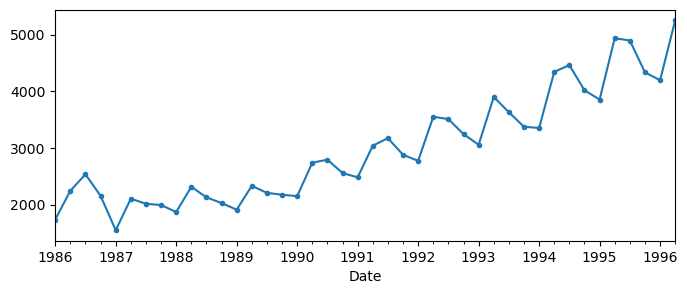

In [15]:
# creating a Line Plot
cola1['Sales'].plot(figsize=(8,3), marker='.')
plt.show()

We can observe that there is an increment in the trend.

Hence, the time series is non-stationary.

##### Histogram  Plot

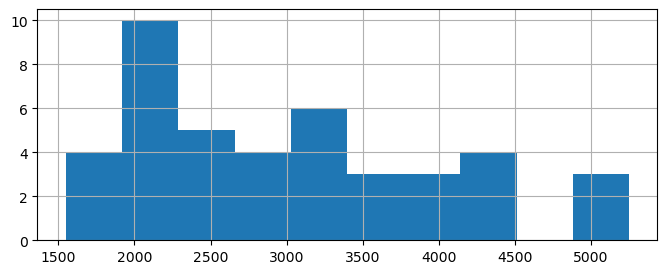

In [16]:
# Plotting a Histogram
cola1['Sales'].hist(figsize=(8,3))
plt.show()

##### Density Plot

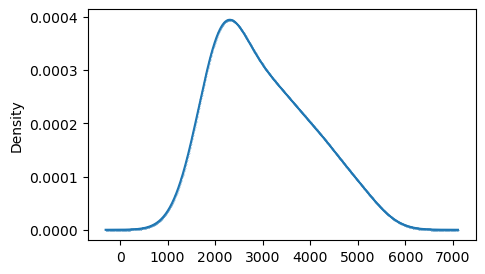

In [17]:
# creating Density Plot
cola1['Sales'].plot(kind='kde', figsize=(5,3), marker='.', markersize=0.3)
plt.show()

##### Box Plot

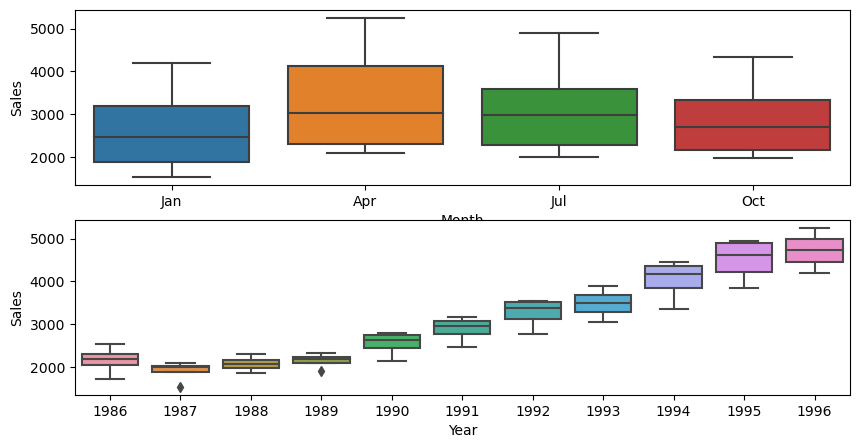

In [18]:
# Boxplot for each year by monthly intervals
plt.figure(figsize=(10,5))
plt.subplot(211)
sns.boxplot(x="Month", y="Sales", data=cola);
plt.subplot(212)
sns.boxplot(x="Year", y="Sales", data=cola);

##### Lag Plot

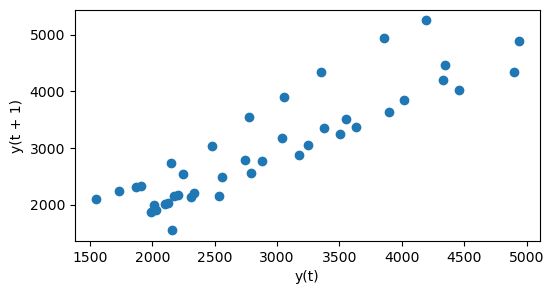

In [19]:
# creating Scatter Plot
plt.figure(figsize=(6,3))
lag_plot(cola1.Sales)
plt.show()

### Moving Average

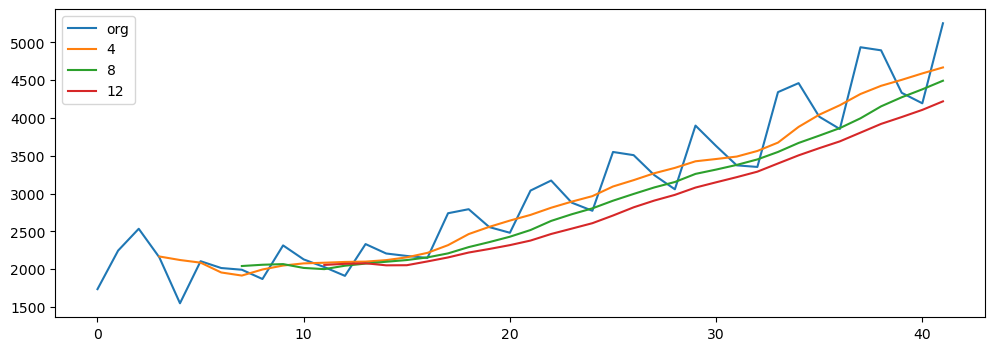

In [20]:
plt.figure(figsize=(12,4))
cola.Sales.plot(label='org')
for i in range(4,16,4):
    cola['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

#### Time series decomposition plot

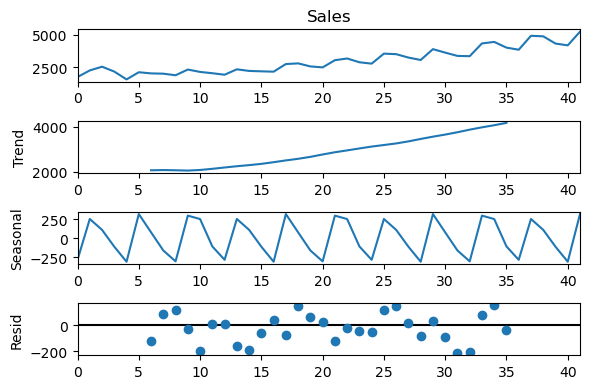

In [21]:
decomp = seasonal_decompose(cola.Sales, period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(6,4))
    decomp.plot()
    plt.show()

#### Autocorrelation Plot (ACF)

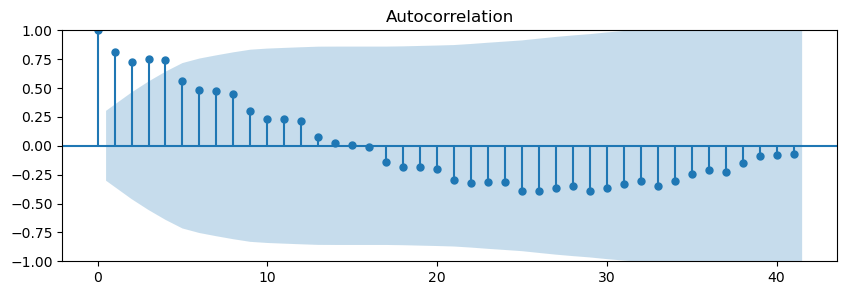

In [22]:
# creating an Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
with plt.rc_context():
    plt.rc("figure", figsize=(10,3))
    plot_acf(cola.Sales,lags=41)
    plt.show()

#### Partial Autocorrelation Plot (PACF)

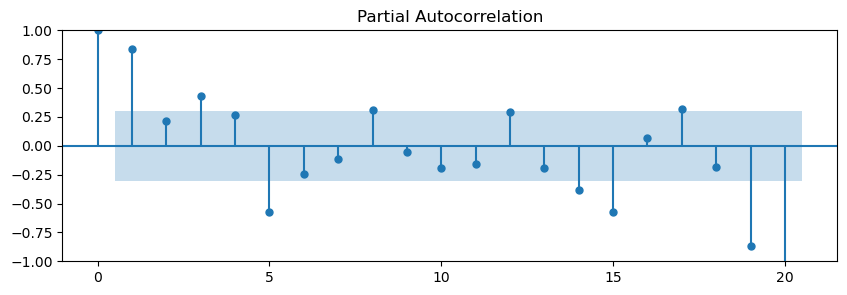

In [23]:
# creating an Autocorrelation plot
from statsmodels.graphics.tsaplots import plot_pacf
with plt.rc_context():
    plt.rc("figure", figsize=(10,3))
    plot_pacf(cola.Sales,lags=20)
    plt.show()

## Data Preprocessing

In [24]:
# getting dummies of the Month column and performing concatenation
month_dummies = pd.DataFrame(pd.get_dummies(cola['Month']))
data = pd.concat([cola, month_dummies],axis = 1)
data.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,Month,Year,Apr,Jan,Jul,Oct
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986,0,1,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986,1,0,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987,0,1,0,0
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987,1,0,0,0
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987,0,0,1,0
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987,0,0,0,1
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988,0,1,0,0
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988,1,0,0,0


#### Applying Transformations

In [25]:
data["t"] = np.arange(1,43)
data["t_sq"] = data["t"]*data["t"]
data["log"] = np.log(data["Sales"])

data.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Month,Year,Apr,Jan,Jul,Oct,t,t_sq,log
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986,0,1,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986,1,0,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987,0,1,0,0,5,25,7.344602


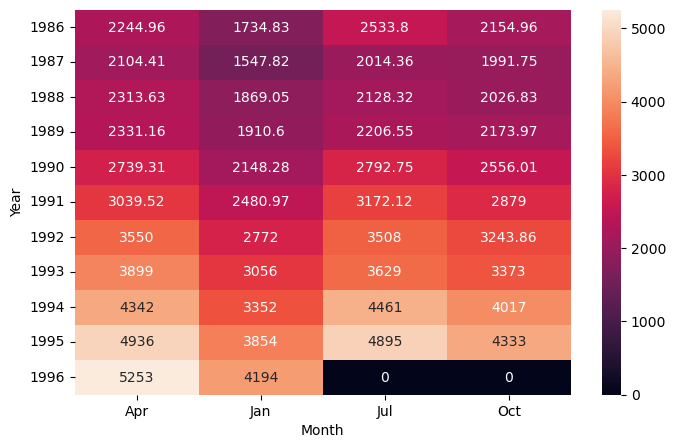

In [26]:
# plotting heatmap between months and years
plt.figure(figsize=(8,5))
Y_month = pd.pivot_table(data=data, values="Sales", index="Year", 
                         columns="Month", aggfunc="mean", fill_value=0)
sns.heatmap(Y_month, annot=True, fmt="g");

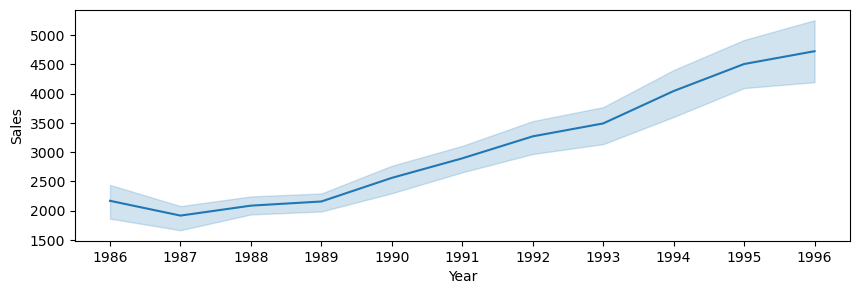

In [27]:
# creating lineplot
plt.figure(figsize=(10,3))
sns.lineplot(x="Year", y="Sales", data=data);

So, from all the plots we can observe that the dataset has upward exponential trend with multiplicative seasonality.

### Splitting the Data

In [28]:
# splitting the data into train and test data
train = data.head(38)
test = data.tail(4)

In [29]:
# printing the dimensions of the train and test data
print(train.shape)
print(test.shape) 

(38, 14)
(4, 14)


### Evaluation Metrics - RMSE & MAPE

In [30]:
def RMSE(pred, org):
    air = np.mean((pred-org)**2)
    return np.sqrt(air)

In [31]:
def MAPE(pred, org):
    air = np.abs(((pred-org)/org)*100)
    return np.mean(air)

# Building Models

### LINEAR MODEL

In [32]:
# Fitting the linear model and predicting
lin_model = smf.ols("Sales~t", data=train).fit()
lin_pred = pd.Series(lin_model.predict(pd.DataFrame(test["t"])))
lin_pred

38    4145.466199
39    4213.536208
40    4281.606217
41    4349.676226
dtype: float64

In [33]:
# To get RMSE of the linear model
lin_rmse = RMSE(lin_pred, test['Sales'])
print('RMSE of the Linear Model : ',lin_rmse)

# To get MAPE of the linear model
lin_mape = MAPE(lin_pred, test['Sales'])
print('MAPE of the Linear Model : ',lin_mape)

RMSE of the Linear Model :  591.5532957223963
MAPE of the Linear Model :  9.338622188445115


### EXPONENTIAL MODEL

In [34]:
# Fitting the exponential model and predicting
exp_model = smf.ols("log~t", data=train).fit()
exp_pred = np.exp(pd.Series(exp_model.predict(pd.DataFrame(test["t"]))))
exp_pred

38    4295.822022
39    4399.046102
40    4504.750549
41    4612.994962
dtype: float64

In [35]:
# To get RMSE of the exponential model
exp_rmse = RMSE(exp_pred, test['Sales'])
print('RMSE of the Exponential Model : ',exp_rmse)

# To get MAPE of the exponential model
exp_mape = MAPE(exp_pred, test['Sales'])
print('MAPE of the Exponential Model : ',exp_mape)

RMSE of the Exponential Model :  466.24797310672346
MAPE of the Exponential Model :  8.339472012060988


### QUADRATIC MODEL

In [36]:
# Fitting the quadratic model and predicting
quad_model = smf.ols("Sales ~ t+t_sq", data=train).fit()
quad_pred = pd.Series(quad_model.predict(pd.DataFrame(test[["t","t_sq"]])))
quad_pred

38    4669.104172
39    4817.733869
40    4970.391551
41    5127.077217
dtype: float64

In [37]:
# To get RMSE of the quadratic model
quad_rmse = RMSE(quad_pred, test['Sales'])
print('RMSE of the Quadratic Model : ',quad_rmse)

# To get MAPE of the quadratic model
quad_mape = MAPE(quad_pred, test['Sales'])
print('MAPE of the Quadratic Model : ',quad_mape)

RMSE of the Quadratic Model :  475.56183518315095
MAPE of the Quadratic Model :  9.177743216665803


## Exponential Smoothing

In [38]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### SIMPLE EXPONENTIAL METHOD

In [39]:
# Fitting the simple exponential model and predicting
sim_exp_m = SimpleExpSmoothing(train["Sales"]).fit(smoothing_level=0.2)
sim_exp_pred = sim_exp_m.predict(start=test.index[0], end=test.index[-1])
sim_exp_pred

38    4020.476391
39    4020.476391
40    4020.476391
41    4020.476391
dtype: float64

In [40]:
# To get RMSE of the simple exponential model
sim_exp_rmse = RMSE(sim_exp_pred, test['Sales'])
print('RMSE of the Simple Exponential Model : ',sim_exp_rmse)

# To get MAPE of the simple exponential model
sim_exp_mape = MAPE(sim_exp_pred, test['Sales'])
print('MAPE of the Simple Exponential Model : ',sim_exp_mape)

RMSE of the Simple Exponential Model :  776.4804305940238
MAPE of the Simple Exponential Model :  13.169736658156928


### HOLT METHOD

In [41]:
# Fitting the model using HOLT method and predicting
holt_model = Holt(train["Sales"]).fit(smoothing_trend=0.2)
holt_pred = holt_model.predict(start=test.index[0], end=test.index[-1])
holt_pred

38    4725.808390
39    4876.605982
40    5027.403574
41    5178.201165
dtype: float64

In [42]:
# To get RMSE of the model using holt method
holt_rmse = RMSE(holt_pred, test['Sales'])
print('RMSE of the Holt Model : ',holt_rmse)

# To get MAPE of the model using holt method
holt_mape = MAPE(holt_pred, test['Sales'])
print('MAPE of the Holt Model : ',holt_mape)

RMSE of the Holt Model :  506.0359785577701
MAPE of the Holt Model :  9.324347828585381


### HOLTS WINTER EXPONENTIAL SMOOTHENING 
    with multiplicative seasonality and additive trend

In [43]:
# Fitting the model using HOLTs winter exponential smoothening method and predicting
holt_exp_mm = ExponentialSmoothing(train["Sales"], seasonal="mul", 
                                   trend="add", seasonal_periods=12).fit()
holt_exp_pred = holt_exp_mm.predict(start=test.index[0], end=test.index[-1])
holt_exp_pred

38    4950.803315
39    4509.430773
40    4018.470476
41    5141.170834
dtype: float64

In [44]:
# To get RMSE of the model using holts exponential method
holt_exp_m_rmse = RMSE(holt_exp_pred, test['Sales'])
print('RMSE of the Holts Exponential Smoothening(mul) Model : ',holt_exp_m_rmse)

# To get MAPE of the model using holts exponential method
holt_exp_m_mape = MAPE(holt_exp_pred, test['Sales'])
print('MAPE of the Holt Exponential Smoothening(mul) Model : ',holt_exp_m_mape)

RMSE of the Holts Exponential Smoothening(mul) Model :  139.24636774491827
MAPE of the Holt Exponential Smoothening(mul) Model :  2.8814787977226395


### HOLTS WINTER EXPONENTIAL SMOOTHENING
    with additive seasonality and additive trend

In [45]:
# Fitting the model using HOLTs winter exponential smoothening method and predicting
holt_exp_am = ExponentialSmoothing(train["Sales"], seasonal="add", 
                                   trend="add", seasonal_periods=12).fit()
holt_exp_pred = holt_exp_am.predict(start=test.index[0], end=test.index[-1])
holt_exp_pred

38    5013.147437
39    4870.382228
40    4701.113334
41    5487.217430
dtype: float64

In [46]:
# To get RMSE of the model using holts exponential method
holt_exp_a_rmse = RMSE(holt_exp_pred, test['Sales'])
print('RMSE of the Holts Exponential Smoothening(add) Model : ',holt_exp_a_rmse)

# To get MAPE of the model using holts exponential method
holt_exp_a_mape = MAPE(holt_exp_pred, test['Sales'])
print('MAPE of the Holt Exponential Smoothening(add) Model : ',holt_exp_a_mape)

RMSE of the Holts Exponential Smoothening(add) Model :  392.0332300587271
MAPE of the Holt Exponential Smoothening(add) Model :  7.841463593306726


## Seasonalities

### ADDITIVE SEASONALITY

In [47]:
# Fitting the model using additive seasonality and predicting
adds_model = smf.ols("Sales ~ Apr+Jan+Jul+Oct", data=train).fit()
adds_pred = pd. Series(adds_model.predict(pd.DataFrame(test[['Apr','Jan','Jul','Oct']])))
adds_pred

38    2938.434220
39    2712.930886
40    2472.555199
41    3150.000098
dtype: float64

In [48]:
# To get RMSE of the model using additive seasonality
adds_rmse = RMSE(adds_pred, test['Sales'])
print('RMSE of the Additive Seasonality Model : ',adds_rmse)

# To get MAPE of the model using additive seasonality 
adds_mape = MAPE(adds_pred, test['Sales'])
print('MAPE of the Additive Seasonality Model : ',adds_mape)

RMSE of the Additive Seasonality Model :  1860.023815454728
MAPE of the Additive Seasonality Model :  39.60986706626122


### ADDITIVE SEASONALITY WITH QUADRATIC TREND

In [49]:
# Fitting the model using additive seasonality with quadratic trend and predicting
adds_quad_m = smf.ols("Sales ~ t+t_sq+Apr+Jan+Jul+Oct", data=train).fit()
adds_quad_pred = pd.Series(adds_quad_m.predict(pd.DataFrame(test[["t","t_sq",'Apr','Jan','Jul','Oct']])))
adds_quad_pred

38    4852.677797
39    4709.186074
40    4638.364982
41    5406.022652
dtype: float64

In [50]:
# To get RMSE of the model using additive seasonality with quadratic trend
adds_quad_rmse = RMSE(adds_quad_pred, test['Sales'])
print('RMSE of the Additive Seasonality (Quad Trend) Model : ',adds_quad_rmse)

# To get MAPE of the model using additive seasonality with quadratic trend
adds_quad_mape = MAPE(adds_quad_pred, test['Sales'])
print('MAPE of the Additive Seasonality (Quad Trend) Model : ',adds_quad_mape)

RMSE of the Additive Seasonality (Quad Trend) Model :  301.7380071935316
MAPE of the Additive Seasonality (Quad Trend) Model :  5.763698214694163


### MULTIPLICATIVE SEASONALITY 

In [51]:
# Fitting the model using multiplicative seasonality and predicting
muls_model = smf.ols("log ~ Apr+Jan+Jul+Oct", data=train).fit()
muls_pred = np.exp(pd.Series(muls_model.predict(pd.DataFrame(test[['Apr','Jan','Jul','Oct']]))))
muls_pred

38    2841.058902
39    2634.665177
40    2370.087030
41    3019.186717
dtype: float64

In [52]:
# To get RMSE of the model using multiplicative seasonality
muls_rmse = RMSE(muls_pred, test['Sales'])
print('RMSE of the Multiplicative Seasonality Model : ',muls_rmse)

# To get MAPE of the model using multiplicative seasonality 
muls_mape = MAPE(muls_pred, test['Sales'])
print('MAPE of the Multiplicative Seasonality Model : ',muls_mape)

RMSE of the Multiplicative Seasonality Model :  1963.3896400779722
MAPE of the Multiplicative Seasonality Model :  41.79212232424086


### MULTIPLICATIVE ADDITIVE SEASONALITY 

In [53]:
# Fitting the model using multiplicative additive seasonality and predicting
mul_adds_m = smf.ols("log ~ t+Apr+Jan+Jul+Oct", data=train).fit()
mul_adds_pred = np.exp(pd.Series(mul_adds_m.predict(pd.DataFrame(test[["t",'Apr','Jan','Jul','Oct']]))))
mul_adds_pred

38    4555.076459
39    4224.164912
40    3983.650879
41    5074.659987
dtype: float64

In [54]:
# To get RMSE of the model using multiplicative seasonality
mul_adds_rmse = RMSE(mul_adds_pred, test['Sales'])
print('RMSE of the Multiplicative Additive Seasonality Model : ',mul_adds_rmse)

# To get MAPE of the model using multiplicative seasonality 
mul_adds_mape = MAPE(mul_adds_pred, test['Sales'])
print('MAPE of the Multiplicative Additve Seasonality Model : ',mul_adds_mape)

RMSE of the Multiplicative Additive Seasonality Model :  225.5243904982743
MAPE of the Multiplicative Additve Seasonality Model :  4.4666408243240125


## ARIMA MODEL

In [55]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [56]:
# making the Date column as DateTime Index for the dataframe
data1 = data.copy()
data1.set_index('Date',inplace=True)
data1.reset_index(inplace=True)
data1.head()

,Date,Quarter,Sales,Quarter_Year,Quarters,Month,Year,Apr,Jan,Jul,Oct,t,t_sq,log
0,1986-01-01,Q1_86,1734.827000,Q1 1986,Q1,Jan,1986,0,1,0,0,1,1,7.458663
1,1986-04-01,Q2_86,2244.960999,Q2 1986,Q2,Apr,1986,1,0,0,0,2,4,7.716443
2,1986-07-01,Q3_86,2533.804993,Q3 1986,Q3,Jul,1986,0,0,1,0,3,9,7.837477
3,1986-10-01,Q4_86,2154.962997,Q4 1986,Q4,Oct,1986,0,0,0,1,4,16,7.675529
4,1987-01-01,Q1_87,1547.818996,Q1 1987,Q1,Jan,1987,0,1,0,0,5,25,7.344602


                  Sales
Date                   
1986-01-01  1734.827000
1986-04-01  2244.960999
1986-07-01  2533.804993
1986-10-01  2154.962997
1987-01-01  1547.818996


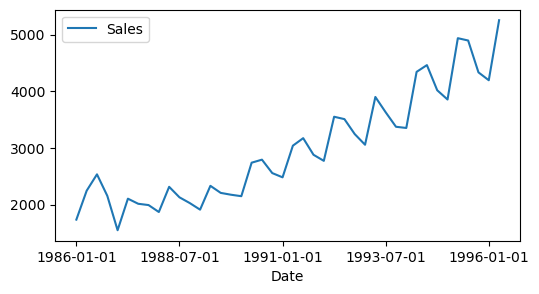

In [57]:
# Making the data as stationary and printing 
data2 = data1[["Date", "Sales"]]
data2.to_csv("data3.csv", index=False)
df = pd.read_csv("data3.csv", index_col=0)
print(df.head())
# visualizing
df.plot(figsize=(6,3))
plt.show()

In [58]:
# Evaluating the data
testr = adfuller(df['Sales'])

Null Hypothesis Ho : It is non-stationary

Alter Hypothesis H1 : It is stationary

In [59]:
def adfuller_test(Sales):
    result=adfuller(Sales)
    labels = ['ADF Test Statistic','p-value','Lags Used','No. of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), So reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(df['Sales'])

ADF Test Statistic : 1.3094210153268107
p-value : 0.9966611673930905
Lags Used : 7
No. of Observations Used : 34
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Transformations

In [60]:
# Applying the Transformations on the data

# Logarithm
df['log'] = np.log(df['Sales'])
print('LOG : \n\n',df.head(),'\n')
print(adfuller_test(df['log'])) 
# ignore None in the output as it's resulting due to printing 

# Square Root
df['sqrt'] = np.sqrt(df['Sales'])
print('\n\n\nSQRT : \n\n',df.head(),'\n')
print(adfuller_test(df['sqrt']))

# Combination of SquareRoot and Log
df['log_sq'] = np.sqrt(df['Sales'])
print('\n\n\nCombination of SQRT & LOG : \n\n',df.head(),'\n')
adfuller_test(df['log_sq'])

LOG : 

                   Sales       log
Date                             
1986-01-01  1734.827000  7.458663
1986-04-01  2244.960999  7.716443
1986-07-01  2533.804993  7.837477
1986-10-01  2154.962997  7.675529
1987-01-01  1547.818996  7.344602 

ADF Test Statistic : 0.1928204385906643
p-value : 0.9718560271303514
Lags Used : 6
No. of Observations Used : 35
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None



SQRT : 

                   Sales       log       sqrt
Date                                        
1986-01-01  1734.827000  7.458663  41.651254
1986-04-01  2244.960999  7.716443  47.381019
1986-07-01  2533.804993  7.837477  50.336915
1986-10-01  2154.962997  7.675529  46.421579
1987-01-01  1547.818996  7.344602  39.342331 

ADF Test Statistic : 0.8285941148596813
p-value : 0.9920839871686823
Lags Used : 6
No. of Observations Used : 35
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-

In [61]:
# Differencing
df['Seasonal_Diff'] = df['Sales']-df['Sales'].shift(4)
print('\n\n\nSeasonal Difference : \n\n',df.head(15),'\n')
print(adfuller_test(df['Seasonal_Diff'].dropna()))

# Log transform with Differencing
df['log_diff'] = df['log']-df['log'].shift(4)
print('\n\n\nLOG trnasform with Seasonal Difference : \n\n',df.head(15),'\n')
adfuller_test(df['log_diff'].dropna())




Seasonal Difference : 

                   Sales       log       sqrt     log_sq  Seasonal_Diff
Date                                                                  
1986-01-01  1734.827000  7.458663  41.651254  41.651254            NaN
1986-04-01  2244.960999  7.716443  47.381019  47.381019            NaN
1986-07-01  2533.804993  7.837477  50.336915  50.336915            NaN
1986-10-01  2154.962997  7.675529  46.421579  46.421579            NaN
1987-01-01  1547.818996  7.344602  39.342331  39.342331    -187.008003
1987-04-01  2104.411995  7.651791  45.873871  45.873871    -140.549004
1987-07-01  2014.362999  7.608058  44.881655  44.881655    -519.441994
1987-10-01  1991.746998  7.596767  44.628993  44.628993    -163.216000
1988-01-01  1869.049999  7.533186  43.232511  43.232511     321.231003
1988-04-01  2313.631996  7.746574  48.100229  48.100229     209.220001
1988-07-01  2128.320000  7.663088  46.133719  46.133719     113.957001
1988-10-01  2026.828999  7.614228  45.020318  45.

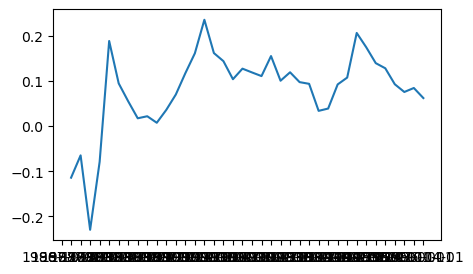

In [62]:
plt.figure(figsize=(5,3))
plt.plot(df['log_diff'])
plt.show()

#### Splitting the Data

In [63]:
# Splitting the data

df1 = pd.read_csv("data3.csv", index_col=0)
split_point = len(df1)-4
dataset, validation = df1[0:split_point], df1[split_point:]
print("Dataset: %d, Validation: %d" % (len(dataset), len(validation)))

dataset.to_csv("dataset.csv", header=False)
validation.to_csv("validation.csv", header=False)

Dataset: 38, Validation: 4


#### Base Model

In [64]:
# Persistence / Base Model

train = pd.read_csv("dataset.csv", header=None, index_col=0,
                     parse_dates=True, squeeze=True)
X = train.values
X = X.astype("float32")
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [X for X in train]
predictions = list()
for i in range (len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs) 
    print("Predicted: %.3f, Expected: %.3f" % (yhat, obs))
        
rmse = sqrt(mean_squared_error(test, predictions))
print("\nRMSE: %.3f" % rmse)

Predicted: 2792.754, Expected: 2556.010
Predicted: 2556.010, Expected: 2480.974
Predicted: 2480.974, Expected: 3039.523
Predicted: 3039.523, Expected: 3172.116
Predicted: 3172.116, Expected: 2879.001
Predicted: 2879.001, Expected: 2772.000
Predicted: 2772.000, Expected: 3550.000
Predicted: 3550.000, Expected: 3508.000
Predicted: 3508.000, Expected: 3243.860
Predicted: 3243.860, Expected: 3056.000
Predicted: 3056.000, Expected: 3899.000
Predicted: 3899.000, Expected: 3629.000
Predicted: 3629.000, Expected: 3373.000
Predicted: 3373.000, Expected: 3352.000
Predicted: 3352.000, Expected: 4342.000
Predicted: 4342.000, Expected: 4461.000
Predicted: 4461.000, Expected: 4017.000
Predicted: 4017.000, Expected: 3854.000
Predicted: 3854.000, Expected: 4936.000

RMSE: 483.351


#### Building the Model based on the optimized values

In [65]:
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
df = train.values
df = df.astype("float32")
test = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [66]:
arima_model = ARIMA(df, order=(0,1,4)).fit()
forecast = arima_model.forecast(steps=12)
forecast

array([5057.2841037 , 4683.28913091, 4671.58724766, 5224.73174966,
       5224.73174966, 5224.73174966, 5224.73174966, 5224.73174966,
       5224.73174966, 5224.73174966, 5224.73174966, 5224.73174966])

In [67]:
# To get RMSE of the ARIMA model
arima_rmse= RMSE(forecast, test[1])
print('RMSE of the ARIMA Model : ',arima_rmse)

# To get MAPE of the ARIMA model
arima_mape = MAPE(forecast, test[1])
print('MAPE of the ARIMA Model : ',arima_mape)

RMSE of the ARIMA Model :  812.3320791848564
MAPE of the ARIMA Model :  18.1528314277388


## Conclusion 

In [68]:
Final = pd.DataFrame({"Model": pd.Series(["linear", "exponential", "quadratic", "simple exponential",
                                          "holt", "holt exponential (Multi)", "holt exponential (add)",
                                          "additive seas", "additive seas with quad", 
                                          "multiplicative seas","multiplicative additive seas","ARIMA"]),
                      "RMSE": pd.Series([lin_rmse, exp_rmse, quad_rmse, sim_exp_rmse, 
                                         holt_rmse, holt_exp_m_rmse, holt_exp_a_rmse, adds_rmse,
                                         adds_quad_rmse, muls_rmse, mul_adds_rmse, arima_rmse]),
                      "MAPE": pd.Series([lin_mape, exp_mape, quad_mape, sim_exp_mape, 
                                         holt_mape, holt_exp_m_mape, holt_exp_a_mape, adds_mape,
                                         adds_quad_mape, muls_mape, mul_adds_mape, arima_mape])})
Final.sort_values(["RMSE"])

,Model,RMSE,MAPE
5,holt exponential (Multi),139.246368,2.881479
10,multiplicative additive seas,225.524390,4.466641
8,additive seas with quad,301.738007,5.763698
6,holt exponential (add),392.033230,7.841464
1,exponential,466.247973,8.339472
2,quadratic,475.561835,9.177743
4,holt,506.035979,9.324348
0,linear,591.553296,9.338622
3,simple exponential,776.480431,13.169737
11,ARIMA,812.332079,18.152831


    We can observe that the model built with 'HOLTS WINTER EXPONENTIAL SMOOTHENING with multiplicative seasonality and additive trend' method gives the best RMSE and MAPE Values.
    Hence, we can conclude that this is the best fit model for Forecasting the CocaCola Sales dataset.